# **CS156 Assignment 3: Yosemite Village yearly weather**

## **Importing necessary libraries**

In [0]:
from glob import glob
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import rbf_kernel 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

## **Loading and Processing the data**

Temperature is cyclical, not only on a 24 hour basis but also on a yearly basis. Convert the dataset into a richer format whereby the day of the year is also captured. For example the time “20150212 1605”, can be converted into (43, 965) because the 12th of February is the 43rd day of the year, and 16:05 is the 965th minute of the day.

In [82]:
# loading data from GDrive
temps = glob('/content/drive/My Drive/yosemite_village/*')

# selecting 3 columns of interest - date, hr/min, temp.
usecols = [1, 2, 8]
data = [np.loadtxt(temp, usecols=usecols) for temp in temps]
data = np.vstack(data)

# convert data to dataframe
df = pd.DataFrame(data)

# renaming the columns
df.rename(columns={0: 'Date', 
                   1: 'Hours, Minutes (HHMM.0)',
                   2: 'Temperature', }, inplace=True)
df.tail()

,Date,"Hours, Minutes (HHMM.0)",Temperature
631291,20131231.0,2340.0,10.8
631292,20131231.0,2345.0,10.5
631293,20131231.0,2350.0,10.5
631294,20131231.0,2355.0,10.5
631295,20140101.0,0.0,10.4


In [83]:
'''removing weird temperature values'''

# check for the minimum temperature (-9999)
min(df.Temperature)
# check for the maximum temperature (normal)
max(df.Temperature)
# check if there are other weird negative temp. values
np.unique(df.Temperature[df.Temperature < -200])
#remove all the -9999 temp. values
df = df[df.Temperature >= -200]
df.head()

,Date,"Hours, Minutes (HHMM.0)",Temperature
0,20110101.0,5.0,-6.4
1,20110101.0,10.0,-6.5
2,20110101.0,15.0,-6.5
3,20110101.0,20.0,-6.5
4,20110101.0,25.0,-6.7


In [84]:
'''converting date and hours to (ddd,mmm) format'''

# convert date to datetime formate
df['Date'] = pd.to_datetime(df['Date'], format = ('%Y%m%d'))

# add new column to show # of days since the beginning of the year
df['Day'] = df['Date'].dt.strftime('%j').astype(int)

df['Min'] = np.floor(
            df['Hours, Minutes (HHMM.0)']/100)*60 + np.mod(
            df['Hours, Minutes (HHMM.0)'], 100)

# extract the year to a new column
df['Year'] = df['Date'].dt.year

df.tail()

,Date,"Hours, Minutes (HHMM.0)",Temperature,Day,Min,Year
631291,2013-12-31,2340.0,10.8,365,1420.0,2013
631292,2013-12-31,2345.0,10.5,365,1425.0,2013
631293,2013-12-31,2350.0,10.5,365,1430.0,2013
631294,2013-12-31,2355.0,10.5,365,1435.0,2013
631295,2014-01-01,0.0,10.4,1,0.0,2014


## **Splitting data into training and test set**

This data covers 6 years, so split the data into a training set of the first 5 years, and a testing set of the 6th year.

In [0]:
split = np.where(np.logical_and(df.Date == '2016-01-01 00:00:00' , df.Min == 0))[0][0]

train = df.iloc[:split]
test = df.iloc[split:]

# converting dataframe to array
train = train.values 
test = test.values

# creating training sets from each of the components
train_mins = np.array(train[:, 4])
train_days = np.array(train[:, 3])
train_temp = np.array(train[:, 2])

# creating test sets from each of the components
test_mins = np.array(test[:, 4])
test_days = np.array(test[:, 3])
test_temp = np.array(test[:, 2])

# reshaping all data sets into columns instead of rows
train_mins, test_mins = train_mins.reshape(-1,1), test_mins.reshape(-1,1)
train_days, test_days = train_days.reshape(-1,1), test_days.reshape(-1,1)
train_temp, test_temp = train_temp.reshape(-1,1), test_temp.reshape(-1,1)

# listing all the minutes and days
mins = df['Min'].values.reshape(-1,1)
days = df['Day'].values.reshape(-1,1)

## **RBF, Linear Regression & R² Analysis**



1.   Cover each input dimension with a list of radial basis functions. This turns the pair of inputs into a much richer representation, mapping (d,t) into (Φ₁(d), Φ₂(t)). Experiment with different numbers of radial basis functions and different widths of the radial basis function in different dimensions.

2.   Using this new representation, build a linear parameter model that captures both seasonal variations and daily variations.

3. Create two plots, one showing the time-of-day contribution, and one showing the time-of-year contribution.

4. Using R², quantify how your model performs on the testing data if you:
  *   Train with just the daily component of the model
  *   Train with just the yearly component of the model
  *   Train with the full model.




In [0]:
def set_centers(min_, max_, num_center):
    '''
    Function to create a bunch of centers for the RBF by 
    dividing the range of chosen data into equal distances
    '''
    center_locs = []
    # base case - if only one center is needed
    if num_center == 1:
        center_locs = [min_, max_]
    # position the centers at equal intervals between the min 
    # and max values
    else:
        center_locs = [i for i in range(min_, max_, max_//(num_center))]
    # reshape the list of centers from row to column
    center_locs = np.asarray((center_locs)).reshape(-1,1)
    return center_locs


def lin_reg(x_scatter, x_train, y_train, x_plot, x_test, y_test, showDays=False, showMins=False):
    '''
    Function that runs linear regression on the training and test data sets.
    
    Inputs: 

      x_scatter: the x-value for the scatterplot, 
                 original training data as input
      x_train: the x-value for the linear regression model,
               rbf training data as input
      y_train: the y-value for the linear regression model,
               training temperature data as input
      x_plot: the x-value for the linear regression line plot,
              original test data as input
      x_test: the 1st value for the linear prediction, 
              rbf test data as input
      y_test: the 2nd value for the linear prediction, 
              test temperature data as input
          
    '''
    # fit a linear regression model to the train and test datasets
    regr = LinearRegression()
    regr.fit(x_train, y_train)
    y_pred_train = regr.predict(x_train)
    y_pred_test = regr.predict(x_test)

    # calculating the R^2 score of the model
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)

    # plotting the linear parameter regression model for 
    # time in year and time in day contributions
    if showDays or showMins:
        
        plt.figure(figsize=(12,8))
        plt.scatter(x_scatter, y_train, label='Data')
        plt.plot(x_plot, y_pred_test, label='Linear prediction', color='r')
        plt.legend(loc='best')
        if showMins:
            plt.xlabel("Min of Day")
        if showDays:
            plt.xlabel("Day of Year")
        plt.ylabel("Temperature (C)")
        plt.show()

    else:
        return r2_train, r2_test, y_pred_test


def RBF(num_rbf, width_list):
    '''
    RBF function
    '''
    global df, all_minutes, all_days, train_temp, test_temp
    test_results = []

    for n in num_rbf:
        for width in width_list:
            
            # setting the list of centers for the minutes
            mins_centers = set_centers(0, 1440, n)
            # setting the list of centers for the days
            days_centers = set_centers(0, 365, n)
            
            # running rbf kernel from scikit-learn for the mins and days
            rbf_mins = rbf_kernel(mins, mins_centers, gamma=1/width)
            rbf_days = rbf_kernel(days, days_centers, gamma=1/width)
            
            # splitting the rbf data to train and test sets
            split = np.where(np.logical_and(df.Date == '2016-01-01 00:00:00' , df.Min == 0.0))[0][0]             
            X_train_mins, X_test_mins = rbf_mins[:split], rbf_mins[split:]
            X_train_days, X_test_days = rbf_days[:split], rbf_days[split:]

            # combining the training and test sets for the rbf mins and rbf days
            # to form the main data set
            X_train = np.concatenate((rbf_mins[:split], rbf_days[:split]), axis=1)   
            X_test = np.concatenate((rbf_mins[split:], rbf_days[split:]), axis=1)       


            
            # Full Model - fit linear regression and obtain R^2 Values
            r2_full, train_r2_full,  y_pred_full = lin_reg(x_scatter=None, 
                                                            x_train=X_train, 
                                                            y_train=train_temp, 
                                                            x_plot=None, 
                                                            x_test=X_test, 
                                                            y_test=test_temp)

            # Days Model - fit linear regression and obtain R^2 Values
            r2_days, train_r2_days, y_pred_days = lin_reg(x_scatter=None, 
                                                            x_train=X_train_days, 
                                                            y_train=train_temp, 
                                                            x_plot=None, 
                                                            x_test=X_test_days, 
                                                            y_test=test_temp)

            ## Minutes Model - fit linear regression and obtain R^2 Values
            r2_mins, train_r2_mins,  y_pred_mins = lin_reg(x_scatter=None, 
                                                            x_train=X_train_mins, 
                                                            y_train=train_temp, 
                                                            x_plot=None, 
                                                            x_test=X_test_mins, 
                                                            y_test=test_temp)

            
            # append the results into the test_results list
            test_results.append([n, width, r2_full, train_r2_full, r2_days, 
                                 train_r2_days, r2_mins, train_r2_mins])
            
    
    # convert the list of lists into a dataframe
    test_results = pd.DataFrame(test_results, columns = 
                                ["Num. Centers","Width","Full Model: Test R^2",
                                 "Full Model: Train R^2","Days: R^2", 
                                 "Train Days: R^2", "Mins: R^2", "Train Mins: R^2"])    

    return test_results 

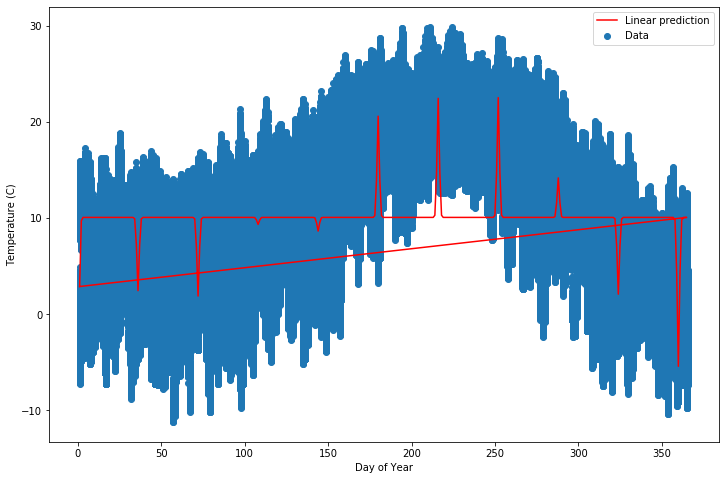

In [98]:
### DAYS component

days_num_centers = 10
days_width = 1

# setting the list of centers for the days
days_centers = set_centers(0, 365, days_num_centers)

#rbf_train_days = rbf_kernel(center_days, center_days, gamma=1/width)
rbf_train_days = rbf_kernel(train_days, days_centers, gamma = 1/days_width)
rbf_test_days = rbf_kernel(test_days, days_centers, gamma = 1/days_width)

lin_reg(x_scatter=train_days, 
        x_train=rbf_train_days, 
        y_train=train_temp, 
        x_plot=test_days, 
        x_test=rbf_test_days, 
        y_test=test_temp, showDays=True)

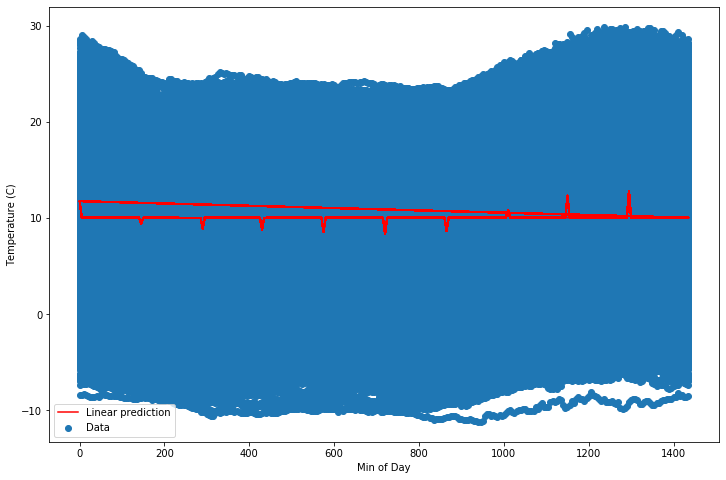

In [97]:
### MINS component

mins_num_centers = 10
mins_width = 1

# setting the list of centers for the days
mins_centers = set_centers(0, 1440, mins_num_centers)

#rbf_train_mins = rbf_kernel(center_days, center_days, gamma=1/width)
rbf_train_mins = rbf_kernel(train_mins, mins_centers, gamma = 1/mins_width)
rbf_test_mins = rbf_kernel(test_mins, mins_centers, gamma = 1/mins_width)

lin_reg(x_scatter=train_mins, 
        x_train=rbf_train_mins, 
        y_train=train_temp, 
        x_plot=test_mins, 
        x_test=rbf_test_mins, 
        y_test=test_temp, showMins=True)

In [93]:
rbf_tests = RBF(num_rbf=[1, 10, 50], width_list=[0.1, 1, 10, 50])
rbf_tests

,Num. Centers,Width,Full Model: Test R^2,Full Model: Train R^2,Days: R^2,Train Days: R^2,Mins: R^2,Train Mins: R^2
0,1,0.1,0.006237,0.002558,0.006070,0.002364,0.000168,-0.000415
1,1,1.0,0.010353,0.000677,0.010006,0.000267,0.000347,-0.000200
2,1,10.0,0.023994,-0.000672,0.023622,-0.001113,0.000374,-0.000170
3,1,50.0,0.048538,-0.003308,0.047913,-0.004048,0.000627,0.000128
4,10,0.1,0.022856,0.012270,0.021840,0.011071,0.001017,0.000588
5,10,1.0,0.053035,0.023826,0.051529,0.022057,0.001507,0.001159
6,10,10.0,0.152633,0.093616,0.150265,0.090833,0.002369,0.002173
7,10,50.0,0.309639,0.224005,0.304564,0.218020,0.005074,0.005373
8,50,0.1,0.080135,0.072718,0.084383,0.075702,0.004645,0.004890
9,50,1.0,0.216744,0.186896,0.208878,0.177567,0.007843,0.008696


## **Analysis**

As seen in the results above, the R² values increases as the number of RBF centers increases. For each of the different conditions that we had, the R² values were the highest when the number of RBF centers was 50. 

The same trend is observed for the width of the RBF - at 0.1, the R² value was abysmal for all 3 of the conditions, but as the width increased to 50, the R² value increased proportionately.

In terms of the 3 conditions that we had - full model, days-only model, and the minutes-only model - the full model had the highest R² values, which makes sense, since the full model should better fit the dataset as it contains all the values. The minutes-only model had the lowest R² values, which makes sense as well, since the time-in-day variation is not very representative of the general dataset. Lastly, the days-only model had R² values that were quite similar to the full model, which tells us that the time-in-year variation is quite representative of the whole model.

The only anomaly that in the results obtained above is for the train-days' R² values when there are 1 RBF center. There, the R² value decreased as the width of the RBF centers increased, which is inconsistent compared to the rest of the results.

Word of caution: Even though we might think that higher values of the number of RBF centers and the width of the RBF is more ideal because it yields larger R² values, this might lead to overfitting, and the model will not be very generalizable to other scenarios. Therefore, it is crucial that we find a sweet spot for the two variables that will give us a balance between model accuracy and generalizability. 